# Forecasting with a CNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-23 09:26:35.281322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

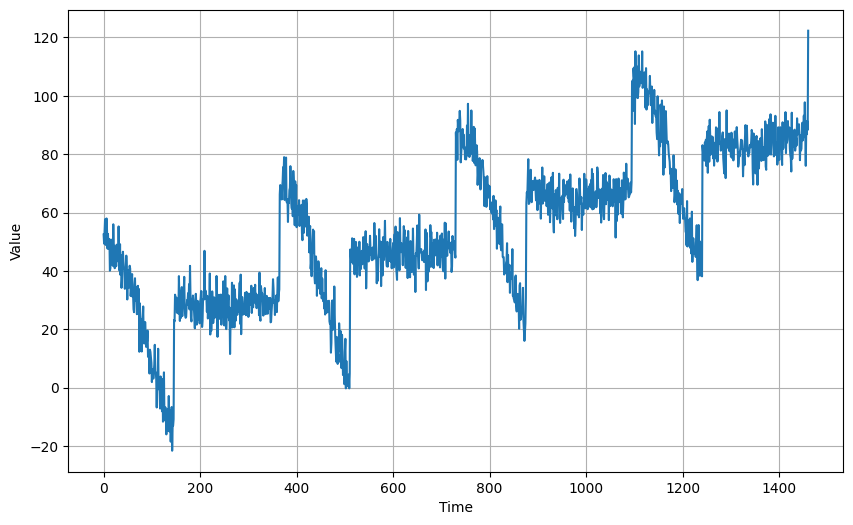

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-23 09:26:39.611960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
8/8 [==============================] - 5s 104ms/step - loss: 59.1209 - mae: 59.6201 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 58.7727 - mae: 59.2718 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 58.2058 - mae: 58.7050 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 57.4997 - mae: 57.9989 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 56.6606 - mae: 57.1599 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 55.7035 - mae: 56.2026 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 54.6121 - mae: 55.1112 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 53.3735 - mae: 53.8726 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 51.9741 - mae: 52.4730 - lr: 2.

(1e-08, 0.0001, 0.0, 30.0)

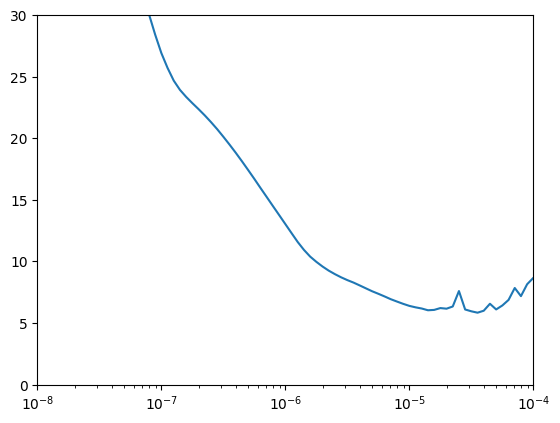

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 188ms/step - loss: 704.3635 - mae: 704.8636 - val_loss: 777.4329 - val_mae: 777.9328
Epoch 2/500
8/8 [==============================] - 0s 36ms/step - loss: 1087.8113 - mae: 1088.3114 - val_loss: 2538.2466 - val_mae: 2538.7468
Epoch 3/500
8/8 [==============================] - 1s 82ms/step - loss: 2193.0459 - mae: 2193.5459 - val_loss: 489.1117 - val_mae: 489.6117
Epoch 4/500
8/8 [==============================] - 1s 55ms/step - loss: 911.9260 - mae: 912.4260 - val_loss: 592.2661 - val_mae: 592.7660
Epoch 5/500
8/8 [==============================] - 1s 55ms/step - loss: 462.8302 - mae: 463.3302 - val_loss: 955.5424 - val_mae: 956.0423
Epoch 6/500
8/8 [==============================] - 0s 50ms/step - loss: 586.6201 - mae: 587.1199 - val_loss: 33.2577 - val_mae: 33.7555
Epoch 7/500
8/8 [==============================] - 0s 49ms/step - loss: 763.2368 - mae: 763.7368 - val_loss: 745.6947 - val_mae: 746.1948
Epoch 8/500
8/8 [============

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


## Mechanized Preprocessing with 1D-Convolutional Layers

In [10]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 3s 24ms/step - loss: 18.8070 - mae: 19.2993 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 18.7794 - mae: 19.2714 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 18.7343 - mae: 19.2260 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 18.6801 - mae: 19.1718 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 18.6192 - mae: 19.1107 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 18.5524 - mae: 19.0440 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 18.4808 - mae: 18.9726 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 18.4046 - mae: 18.8968 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 21ms/s

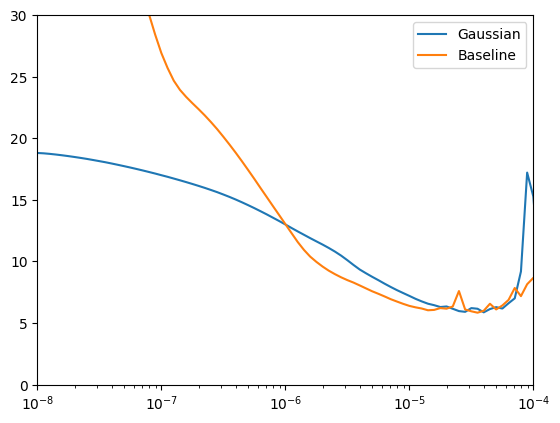

In [18]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.axis([1e-8, 1e-4, 0, 30])
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.legend()


In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, gaussian_model_checkpoint])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      6/Unknown - 3s 24ms/step - loss: 437.6309 - mae: 438.1294In Gaussian Mechanism
8/8 [==============================] - 4s 145ms/step - loss: 383.6920 - mae: 384.1909 - val_loss: 511.0897 - val_mae: 511.5896
Epoch 2/500
8/8 [==============================] - 0s 51ms/step - loss: 426.1848 - mae: 426.6847 - val_loss: 12.6860 - val_mae: 13.1772
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 303.6107 - mae: 304.1102 - val_loss: 261.4612 - val_mae: 261.9615
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 388.7997 - mae: 389.2999 - val_loss: 90.4478 - val_mae: 90.9484
Epoch 5/500
8/8 [==============================] - 0s 39ms/step - loss: 197.4066 - mae: 197.9066 - val_loss: 74.2698 - val_mae: 74.7695
Epoch 6/500
8/8 [==============================] - 0s 34ms/step - loss: 665.7244 - mae: 666.2243 - val_loss: 757.2848 - val_mae: 757.7841
Epoch 7/500
8/8 [==============================]

In [22]:
gaussian_model = keras.models.load_model("gaussian_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [23]:
gaussian_rnn_forecast = model_forecast(gaussian_model, series[:,  np.newaxis], window_size)
gaussian_rnn_forecast = gaussian_rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 6ms/step


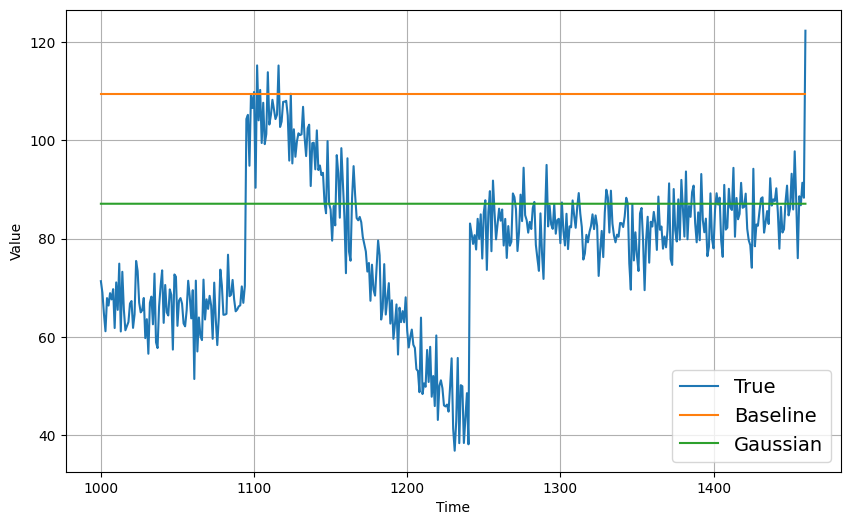

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

31.114359

In [39]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

13.167352

## Fully Convolutional Forecasting

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 29ms/step - loss: 41.8450 - mae: 42.3441 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 41.4736 - mae: 41.9728 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 40.9741 - mae: 41.4733 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 32ms/step - loss: 40.3626 - mae: 40.8616 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 39.5643 - mae: 40.0631 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 38.5575 - mae: 39.0561 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 37.2136 - mae: 37.7123 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 35.3590 - mae: 35.8573 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 32.5700 - mae: 33.0684 - lr: 1.8

(0.0001, 0.1, 0.0, 30.0)

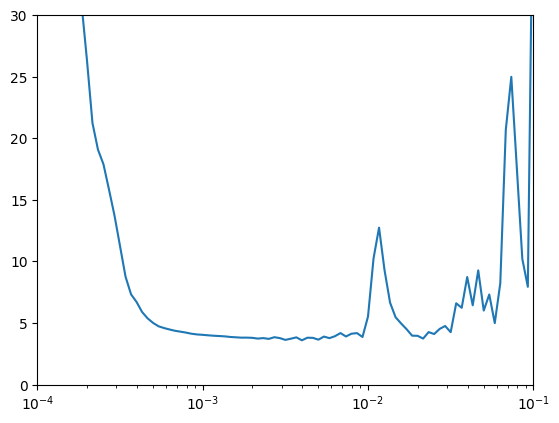

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 93ms/step - loss: 41.6411 - mae: 42.1402 - val_loss: 75.7159 - val_mae: 76.2159
Epoch 2/500
8/8 [==============================] - 0s 41ms/step - loss: 39.2466 - mae: 39.7453 - val_loss: 67.4341 - val_mae: 67.9341
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 31.6820 - mae: 32.1803 - val_loss: 38.4760 - val_mae: 38.9747
Epoch 4/500
8/8 [==============================] - 0s 42ms/step - loss: 19.1321 - mae: 19.6268 - val_loss: 31.1925 - val_mae: 31.6897
Epoch 5/500
8/8 [==============================] - 0s 44ms/step - loss: 15.9193 - mae: 16.4121 - val_loss: 23.3888 - val_mae: 23.8831
Epoch 6/500
8/8 [==============================] - 0s 41ms/step - loss: 12.7354 - mae: 13.2252 - val_loss: 16.9183 - val_mae: 17.4117
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 10.0564 - mae: 10.5432 - val_loss: 12.2974 - val_mae: 12.7839
Epoch 8/500
8/8 [==============================] - 0s 40ms/ste

In [29]:
model = keras.models.load_model("my_checkpoint.h5")

In [30]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 0s 4ms/step


## Fully Mechanized Convolutional Forecast

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential()
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

gaussian_model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    gaussian_model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
gaussian_model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 2s 30ms/step - loss: 41.6430 - mae: 42.1421 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 41.1457 - mae: 41.6450 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 40.5830 - mae: 41.0823 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 39.8828 - mae: 40.3818 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 38.8838 - mae: 39.3825 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 37.3933 - mae: 37.8919 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 35.1407 - mae: 35.6392 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 31.7601 - mae: 32.2580 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 28ms/s

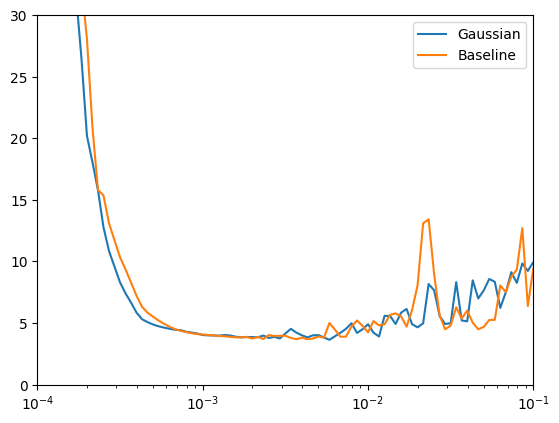

In [47]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.axis([1e-4, 1e-1, 0, 30])
plt.legend()

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential()
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

gaussian_model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    gaussian_model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
gaussian_model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
gaussian_history = gaussian_model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, gaussian_model_checkpoint])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      7/Unknown - 2s 29ms/step - loss: 40.2384 - mae: 40.7373In Gaussian Mechanism
8/8 [==============================] - 2s 93ms/step - loss: 40.1270 - mae: 40.6261 - val_loss: 69.2870 - val_mae: 69.7874
Epoch 2/500
8/8 [==============================] - 0s 39ms/step - loss: 32.5948 - mae: 33.0933 - val_loss: 41.0657 - val_mae: 41.5663
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 18.0339 - mae: 18.5284 - val_loss: 28.0437 - val_mae: 28.5402
Epoch 4/500
8/8 [==============================] - 0s 38ms/step - loss: 13.9537 - mae: 14.4452 - val_loss: 19.9811 - val_mae: 20.4768
Epoch 5/500
8/8 [==============================] - 0s 40ms/step - loss: 10.0946 - mae: 10.5821 - val_loss: 12.2259 - val_mae: 12.7173
Epoch 6/500
8/8 [==============================] - 0s 39ms/step - loss: 7.7612 - mae: 8.2447 - val_loss: 9.8184 - val_mae: 10.3059
Epoch 7/500
8/8 [==============================] - 0s 38ms/step - loss: 

In [34]:
gaussian_model = keras.models.load_model("my_checkpoint.h5")

In [35]:
gaussian_cnn_forecast = model_forecast(gaussian_model, series[..., np.newaxis], window_size)
gaussian_cnn_forecast = gaussian_cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 0s 4ms/step


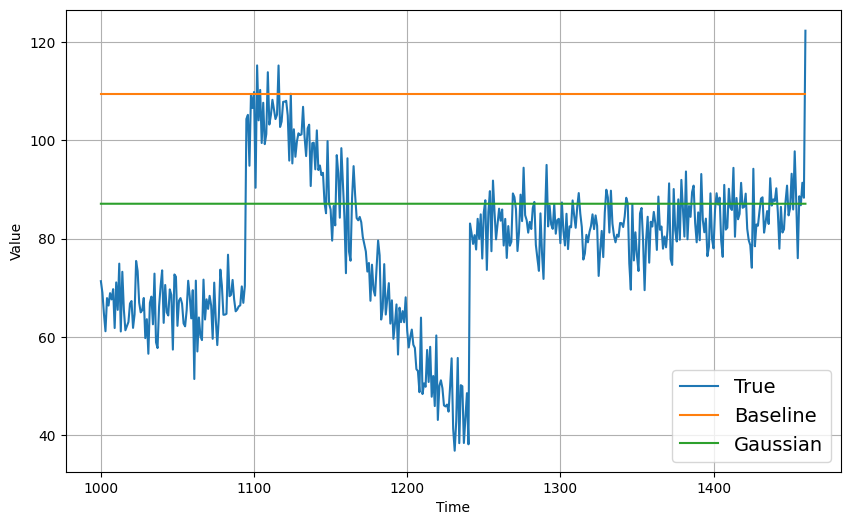

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [37]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.506944

In [38]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

13.167352